# Reshaping & Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

So, you've sat down to analyze a new dataset.
What do you do first?

In episode 11 of [Not So Standard Deviations](https://www.patreon.com/NSSDeviations?ty=h), Hilary and Roger discussed their typical approaches.
I'm with Hilary on this one, you should make sure your data is tidy.
Before you do any plots, filtering, transformations, summary statistics, regressions...
Without a tidy dataset, you'll be fighting your tools to get the result you need.
With a tidy dataset, it's relatively easy to do all of those.

Hadley Wickham kindly summarized tidiness as a dataset where

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

And today we'll only concern ourselves with the first two.
As quoted at the top, this really is about facilitating analysis: going as quickly as possible from question to answer.

In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

## NBA Data

[This](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question asked about calculating the number of days of rest NBA teams have between games.
The answer would have been difficult to compute with the raw data.
After transforming the dataset to be tidy, we're able to quickly get the answer.

We'll grab some NBA game data from basketball-reference.com using pandas' `read_html` function, which returns a list of DataFrames.

In [ ]:
fp = 'nba'
todays = str(pd.Timestamp.today())
print(todays)
todays = todays.split()[0].replace("-","")+".csv"
print(todays)
fp = fp + todays 
print(fp)

2022-02-02 13:34:48.914120
20220202.csv
nba20220202.csv


In [ ]:
if not os.path.exists(fp):
    tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2021_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.tail()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
62,"Thu, Dec 31, 2020",6:30p,Philadelphia 76ers,116,Orlando Magic,92,Box Score,NaN,3247,NaN
63,"Thu, Dec 31, 2020",7:00p,Sacramento Kings,119,Houston Rockets,122,Box Score,NaN,3247,NaN
64,"Thu, Dec 31, 2020",7:30p,New York Knicks,83,Toronto Raptors,100,Box Score,NaN,3449,NaN
65,"Thu, Dec 31, 2020",8:00p,New Orleans Pelicans,113,Oklahoma City Thunder,80,Box Score,NaN,0,NaN
66,"Thu, Dec 31, 2020",9:00p,Phoenix Suns,106,Utah Jazz,95,Box Score,NaN,1932,NaN


Side note: pandas' `read_html` is pretty good. On simple websites it almost always works.
It provides a couple parameters for controlling what gets selected from the webpage if the defaults fail.
I'll always use it first, before moving on to [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) or [lxml](http://lxml.de/) if the page is more complicated.

As you can see, we have a bit of general munging to do before tidying.
Each month slips in an extra row of mostly NaNs, the column names aren't too useful, and we have some dtypes to fix up.

In [ ]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2020-12-22,Golden State Warriors,99,Brooklyn Nets,125
1,2020-12-22,Los Angeles Clippers,116,Los Angeles Lakers,109
2,2020-12-23,Charlotte Hornets,114,Cleveland Cavaliers,121
3,2020-12-23,New York Knicks,107,Indiana Pacers,121
4,2020-12-23,Miami Heat,107,Orlando Magic,113


A quick aside on that last block.

- `dropna` has a `thresh` argument. If at least `thresh` items are missing, the row is dropped. We used it to remove the "Month headers" that slipped into the table.
- `assign` can take a callable. This lets us refer to the DataFrame in the previous step of the chain. Otherwise we would have to assign `temp_df = games.dropna()...` And then do the `pd.to_datetime` on that.
- `set_index` has an `append` keyword. We keep the original index around since it will be our unique identifier per game.
- We use `.rename_axis` to set the index names (this behavior is new in pandas 0.18; before `.rename_axis` only took a mapping for changing labels).

The Question:
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

In this case, an observation is a `(team, game)` pair, which we don't have yet. Rather, we have two observations per row, one for home and one for away. We'll fix that with `pd.melt`.

`pd.melt` works by taking observations that are spread across columns (`away_team`, `home_team`), and melting them down into one column with multiple rows. However, we don't want to lose the metadata (like `game_id` and `date`) that is shared between the observations. By including those columns as `id_vars`, the values will be repeated as many times as needed to stay with their observations.

In [ ]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2020-12-22,away_team,Golden State Warriors
1,1,2020-12-22,away_team,Los Angeles Clippers
2,2,2020-12-23,away_team,Charlotte Hornets
3,3,2020-12-23,away_team,New York Knicks
4,4,2020-12-23,away_team,Miami Heat


The DataFrame `tidy` meets our rules for tidiness: each variable is in a column, and each observation (`team`, `date` pair) is on its own row.
Now the translation from question ("How many days of rest between games") to operation ("date of today's game - date of previous game - 1") is direct:

In [ ]:
# For each team... get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
129    7.0
130    2.0
131    7.0
132    1.0
133    4.0
Name: date, Length: 134, dtype: float64

That's the essence of tidy data, the reason why it's worth considering what shape your data should be in.
It's about setting yourself up for success so that the answers naturally flow from the data (just kidding, it's usually still difficult. But hopefully less so).

Let's assign that back into our DataFrame

In [ ]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
14,14,2020-12-25,away_team,New Orleans Pelicans,1.0
15,15,2020-12-25,away_team,Golden State Warriors,2.0
16,16,2020-12-25,away_team,Brooklyn Nets,2.0
17,17,2020-12-25,away_team,Dallas Mavericks,1.0
18,18,2020-12-25,away_team,Los Angeles Clippers,2.0


To show the inverse of `melt`, let's take `rest` values we just calculated and place them back in the original DataFrame with a `pivot_table`.

In [ ]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
14,2020-12-25,New Orleans Pelicans,98,Miami Heat,111,1.0,1.0
15,2020-12-25,Golden State Warriors,99,Milwaukee Bucks,138,2.0,1.0
16,2020-12-25,Brooklyn Nets,123,Boston Celtics,95,2.0,1.0
17,2020-12-25,Dallas Mavericks,115,Los Angeles Lakers,138,1.0,2.0
18,2020-12-25,Los Angeles Clippers,121,Denver Nuggets,108,2.0,1.0


One somewhat subtle point: an "observation" depends on the question being asked.
So really, we have two tidy datasets, `tidy` for answering team-level questions, and `df` for answering game-level questions.

One potentially interesting question is "what was each team's average days of rest, at home and on the road?" With a tidy dataset (the DataFrame `tidy`, since it's team-level), `seaborn` makes this easy (more on seaborn in a future post):

In [ ]:
sns.set(style='ticks', context='paper')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


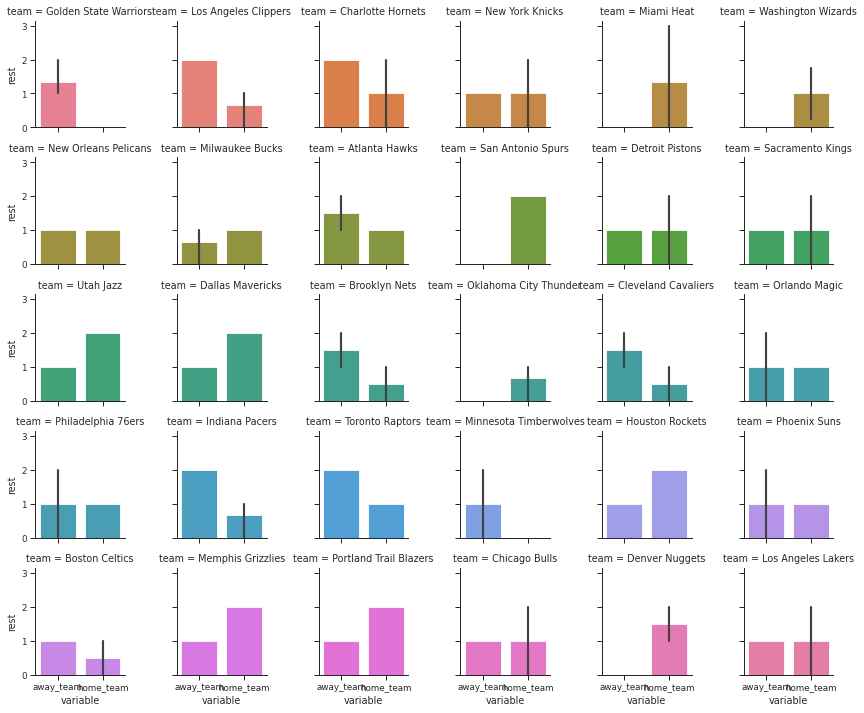

In [ ]:
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

An example of a game-level statistic is the distribution of rest differences in games:

In [ ]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
14,2020-12-25,New Orleans Pelicans,98,Miami Heat,111,1.0,1.0,True,0.0
15,2020-12-25,Golden State Warriors,99,Milwaukee Bucks,138,2.0,1.0,True,-1.0
16,2020-12-25,Brooklyn Nets,123,Boston Celtics,95,2.0,1.0,False,-1.0
17,2020-12-25,Dallas Mavericks,115,Los Angeles Lakers,138,1.0,2.0,True,1.0
18,2020-12-25,Los Angeles Clippers,121,Denver Nuggets,108,2.0,1.0,False,-1.0


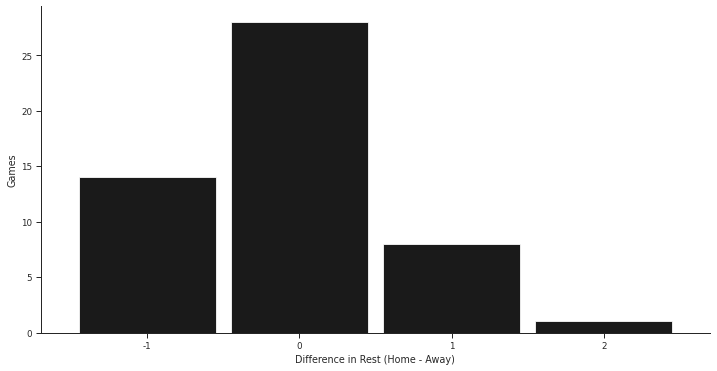

In [ ]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

Or the win percent by rest difference

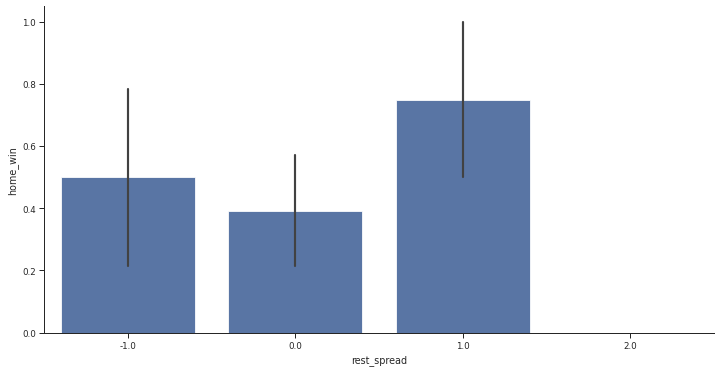

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

## Stack / Unstack

Pandas has two useful methods for quickly converting from wide to long format (`stack`) and long to wide (`unstack`).

In [ ]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2020-12-25  away_team    1.6
            home_team    1.2
2020-12-26  away_team    2.0
            home_team    2.0
2020-12-27  away_team    0.5
Name: rest, dtype: float64

`rest` is in a "long" form since we have a single column of data, with multiple "columns" of metadata (in the MultiIndex). We use `.unstack` to move from long to wide.

In [ ]:
rest.unstack().head()

variable,away_team,home_team
date,,
2020-12-25,1.6,1.2
2020-12-26,2.0,2.0
2020-12-27,0.5,0.3
2020-12-28,1.0,0.8
2020-12-29,1.0,1.0


`unstack` moves a level of a MultiIndex (innermost by default) up to the columns.
`stack` is the inverse.

In [ ]:
rest.unstack().stack()

date        variable 
2020-12-25  away_team    1.600000
            home_team    1.200000
2020-12-26  away_team    2.000000
            home_team    2.000000
2020-12-27  away_team    0.500000
                           ...   
2020-12-29  home_team    1.000000
2020-12-30  away_team    1.000000
            home_team    0.833333
2020-12-31  away_team    1.000000
            home_team    1.285714
Length: 14, dtype: float64

With `.unstack` you can move between those APIs that expect there data in long-format and those APIs that work with wide-format data. For example, `DataFrame.plot()`, works with wide-form data, one line per column.

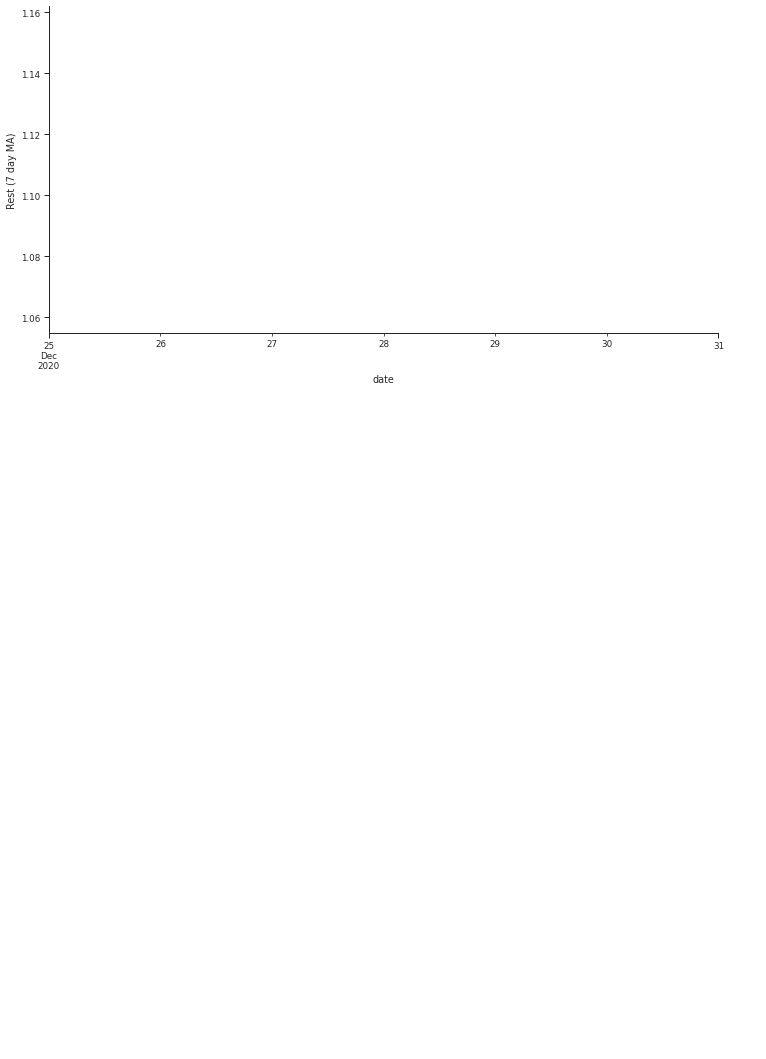

In [ ]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
        .rolling(7)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

The most conenient form will depend on exactly what you're doing.
When interacting with databases you'll often deal with long form data.
Pandas' `DataFrame.plot` often expects wide-form data, while `seaborn` often expect long-form data. Regressions will expect wide-form data. Either way, it's good to be comfortable with `stack` and `unstack` (and MultiIndexes) to quickly move between the two.

## Mini Project: Home Court Advantage?

We've gone to all that work tidying our dataset, let's put it to use.
What's the effect (in terms of probability to win) of being
the home team?

### Step 1: Create an outcome variable

We need to create an indicator for whether the home team won.
Add it as a column called `home_win` in `games`.

In [ ]:
df['home_win'] = df.home_points > df.away_points

### Step 2: Find the win percent for each team

In the 10-minute literature review I did on the topic, it seems like people include a team-strength variable in their regressions.
I suppose that makes sense; if stronger teams happened to play against weaker teams at home more often than away, it'd look like the home-effect is stronger than it actually is.
We'll do a terrible job of controlling for team strength by calculating each team's win percent and using that as a predictor.
It'd be better to use some kind of independent measure of team strength, but this will do for now.

We'll use a similar `melt` operation as earlier, only now with the `home_win` variable we just created.

In [ ]:
wins = (
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
   .rename(columns=dict(sum='n_wins',
                        count='n_games',
                        mean='win_pct'))
)
wins.head()

n_wins  n_games   win_pct
team           is_home                             
Atlanta Hawks  away_team       2        3  0.666667
               home_team       1        1  1.000000
Boston Celtics away_team       1        2  0.500000
               home_team       2        3  0.666667
Brooklyn Nets  away_team       1        2  0.500000

Pause for visualiztion, because why not

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


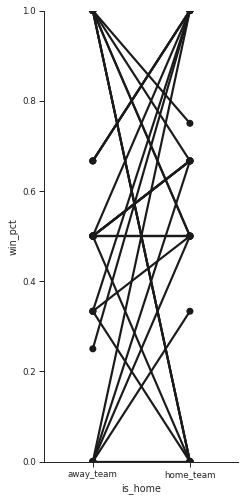

In [ ]:
g = sns.FacetGrid(wins.reset_index(), hue='team', size=7, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'is_home', 'win_pct').set(ylim=(0, 1));

(It'd be great if there was a library built on top of matplotlib that auto-labeled each point decently well. Apparently this is a difficult problem to do in general).

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


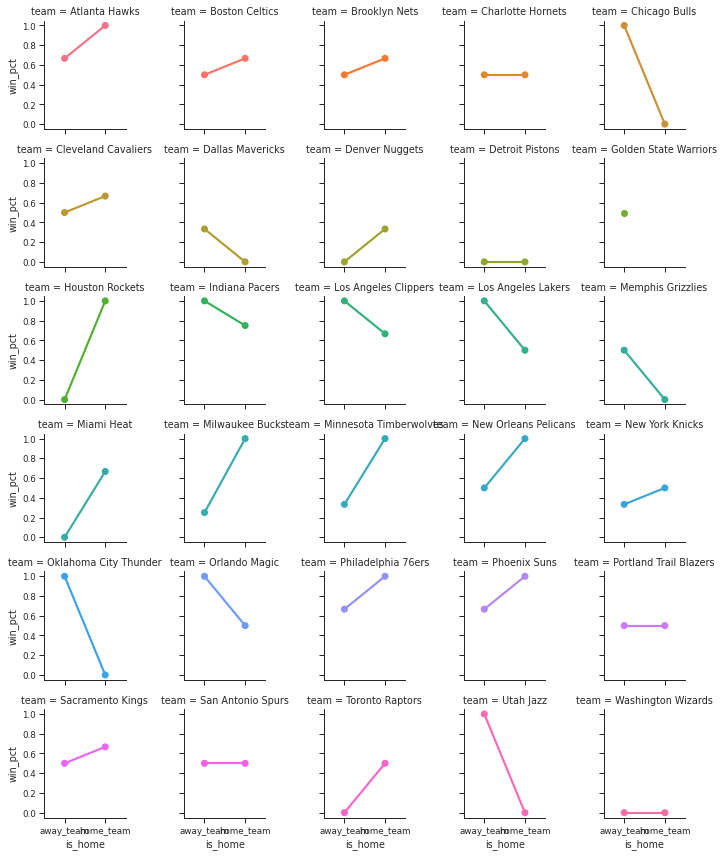

In [ ]:
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, size=2)
g.map(sns.pointplot, 'is_home', 'win_pct')

Those two graphs show that most teams have a higher win-percent at home than away. So we can continue to investigate.
Let's aggregate over home / away to get an overall win percent per team.

In [ ]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level='team', as_index=True)
        .apply(lambda x: x.n_wins.sum() / x.n_games.sum())
)
win_percent.head()

team
Atlanta Hawks        0.75
Boston Celtics       0.60
Brooklyn Nets        0.60
Charlotte Hornets    0.50
Chicago Bulls        0.40
dtype: float64

Text(0.5, 86.7, 'Win Percent')

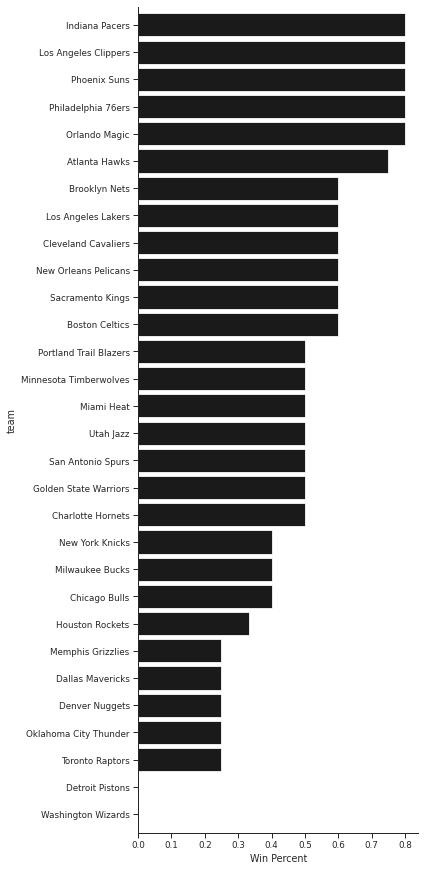

In [ ]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=.85, color='k')
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

Is there a relationship between overall team strength and their home-court advantage?

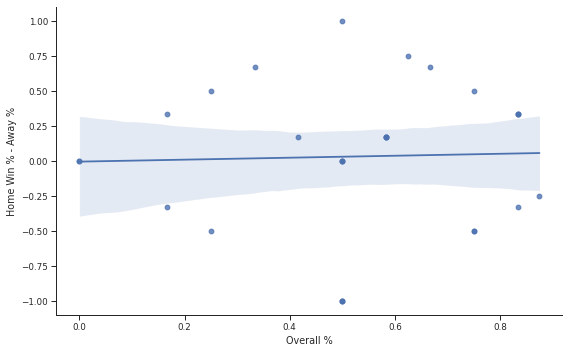

In [ ]:
plt.figure(figsize=(8, 5))
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     .pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)
sns.despine()
plt.tight_layout()

Let's get the team strength back into `df`.
You could you `pd.merge`, but I prefer `.map` when joining a `Series`.

In [ ]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
               home_strength=df['home_team'].map(win_percent),
               point_diff=df['home_points'] - df['away_points'],
               rest_diff=df['home_rest'] - df['away_rest'])
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
0,2020-12-22,Golden State Warriors,99,Brooklyn Nets,125,NaN,NaN,True,NaN,0.5,0.6,26,NaN
1,2020-12-22,Los Angeles Clippers,116,Los Angeles Lakers,109,NaN,NaN,False,NaN,0.8,0.6,-7,NaN
2,2020-12-23,Charlotte Hornets,114,Cleveland Cavaliers,121,NaN,NaN,True,NaN,0.5,0.6,7,NaN
3,2020-12-23,New York Knicks,107,Indiana Pacers,121,NaN,NaN,True,NaN,0.4,0.8,14,NaN
4,2020-12-23,Miami Heat,107,Orlando Magic,113,NaN,NaN,True,NaN,0.5,0.8,6,NaN


In [ ]:
import statsmodels.formula.api as sm

df['home_win'] = df.home_win.astype(int)  # for statsmodels

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
mod = sm.logit('home_win ~ home_strength + away_strength + home_rest + away_rest', df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.541897
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                   51
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            4
Date:                Wed, 02 Feb 2022   Pseudo R-squ.:                  0.2163
Time:                        13:35:57   Log-Likelihood:                -27.637
converged:                       True   LL-Null:                       -35.262
Covariance Type:            nonrobust   LLR p-value:                  0.004208
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5728      1.498      0.382      0.702      -2.364       3.509
home_strength     3.6663      1.526      2.402      0.016       0.675       6.657
away_strength    -3.2806      1.858     -1.766      0.077      -6.922       0.361
home_rest         0.0041      0.464      0.009      0.993      -0.904       0.913
away_rest        -0.6654      0.642     -1.037      0.300      -1.923       0.592
=================================================================================
"""

The strength variables both have large coefficeints (really we should be using some independent measure of team strength here, `win_percent` is showing up on the left and right side of the equation). The rest variables don't seem to matter as much.

With `.assign` we can quickly explore variations in formula.

In [ ]:
(sm.Logit.from_formula('home_win ~ strength_diff + rest_spread',
                       df.assign(strength_diff=df.home_strength - df.away_strength))
                      .fit().summary())

AttributeError: ignored

In [ ]:
mod = sm.Logit.from_formula('home_win ~ home_rest + away_rest', df)
res = mod.fit()
res.summary()

AttributeError: ignored

Overall not seeing to much support for rest mattering, but we got to see some more tidy data.

That's it for today.
Next time we'll look at data visualization.